# Import Library

In [1]:
import numpy as np
import os
import networkx as nx
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from layers import GraphConv
from models import (
    GCN, 
    DNN, 
    InceptionGCN, 
    ResidualGCN, 
    GatedSkipConnectionGCN,
)
from utils import (
    seed_everything, 
    limit_data, 
    encode_label, 
    normalize_Adj,
    draw_history,
    plot_tSNE,
)
import config as C

#### Set Seed

In [2]:
seed_everything(C.SEED)

# Cora Dataset 

In [3]:
all_data = []
all_edges = []

for root, dirs, files in os.walk(C.DATA_PATH):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif '.cites' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data, random_state=C.SEED)

cora.content
1. Node ID
2. Node Feature
3. Node Label

cora.cites

(a, b)

a : ID of the paper being cited

b : the paper containing the citation

In [4]:
labels = []
nodes = []
X = []

for i, data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    
X = np.array(X, dtype=int)
N = X.shape[0]
F = X.shape[1]
print(f'LOG >>> X shape: {X.shape}')

LOG >>> X shape: (2708, 1433)


In [5]:
edge_list = []

for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0], e[1]))
    
print(f'LOG >>> Number of Nodes N : {N}')
print(f'LOG >>> Number of Features F of each node : {F}')
print(f'LOG >>> Categories :\n{set(labels)}')
# num_classes = len(set(labels))
print(f'LOG >>> Number of classes : {C.num_classes}')

LOG >>> Number of Nodes N : 2708
LOG >>> Number of Features F of each node : 1433
LOG >>> Categories :
{'Case_Based', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Theory', 'Neural_Networks', 'Rule_Learning', 'Genetic_Algorithms'}
LOG >>> Number of classes : 7


In [6]:
len(edge_list)

5429

# Set Train, val and test mask 

In [7]:
train_idx, val_idx, test_idx = limit_data(labels)

In [8]:
print(f'LOG >>> Number of Train set : {len(train_idx)}')
print(f'LOG >>> Number of Valid set : {len(val_idx)}')
print(f'LOG >>> Number of Test set : {len(test_idx)}')

LOG >>> Number of Train set : 140
LOG >>> Number of Valid set : 500
LOG >>> Number of Test set : 1000


In [9]:
train_mask = np.zeros((N,), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,), dtype=bool)
test_mask[test_idx] = True

### Get Adjacency Matrix, A 

In [10]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)
print(f'LOG >>> Graph info:\n{nx.info(G)}')

# Normalize A and convert type of X
A = normalize_Adj(A)
X = X.astype(np.float64)

LOG >>> Graph info:
Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


### Encode label with One-Hot

In [11]:
labels_encoded, classes = encode_label(labels)

# Raw Data 

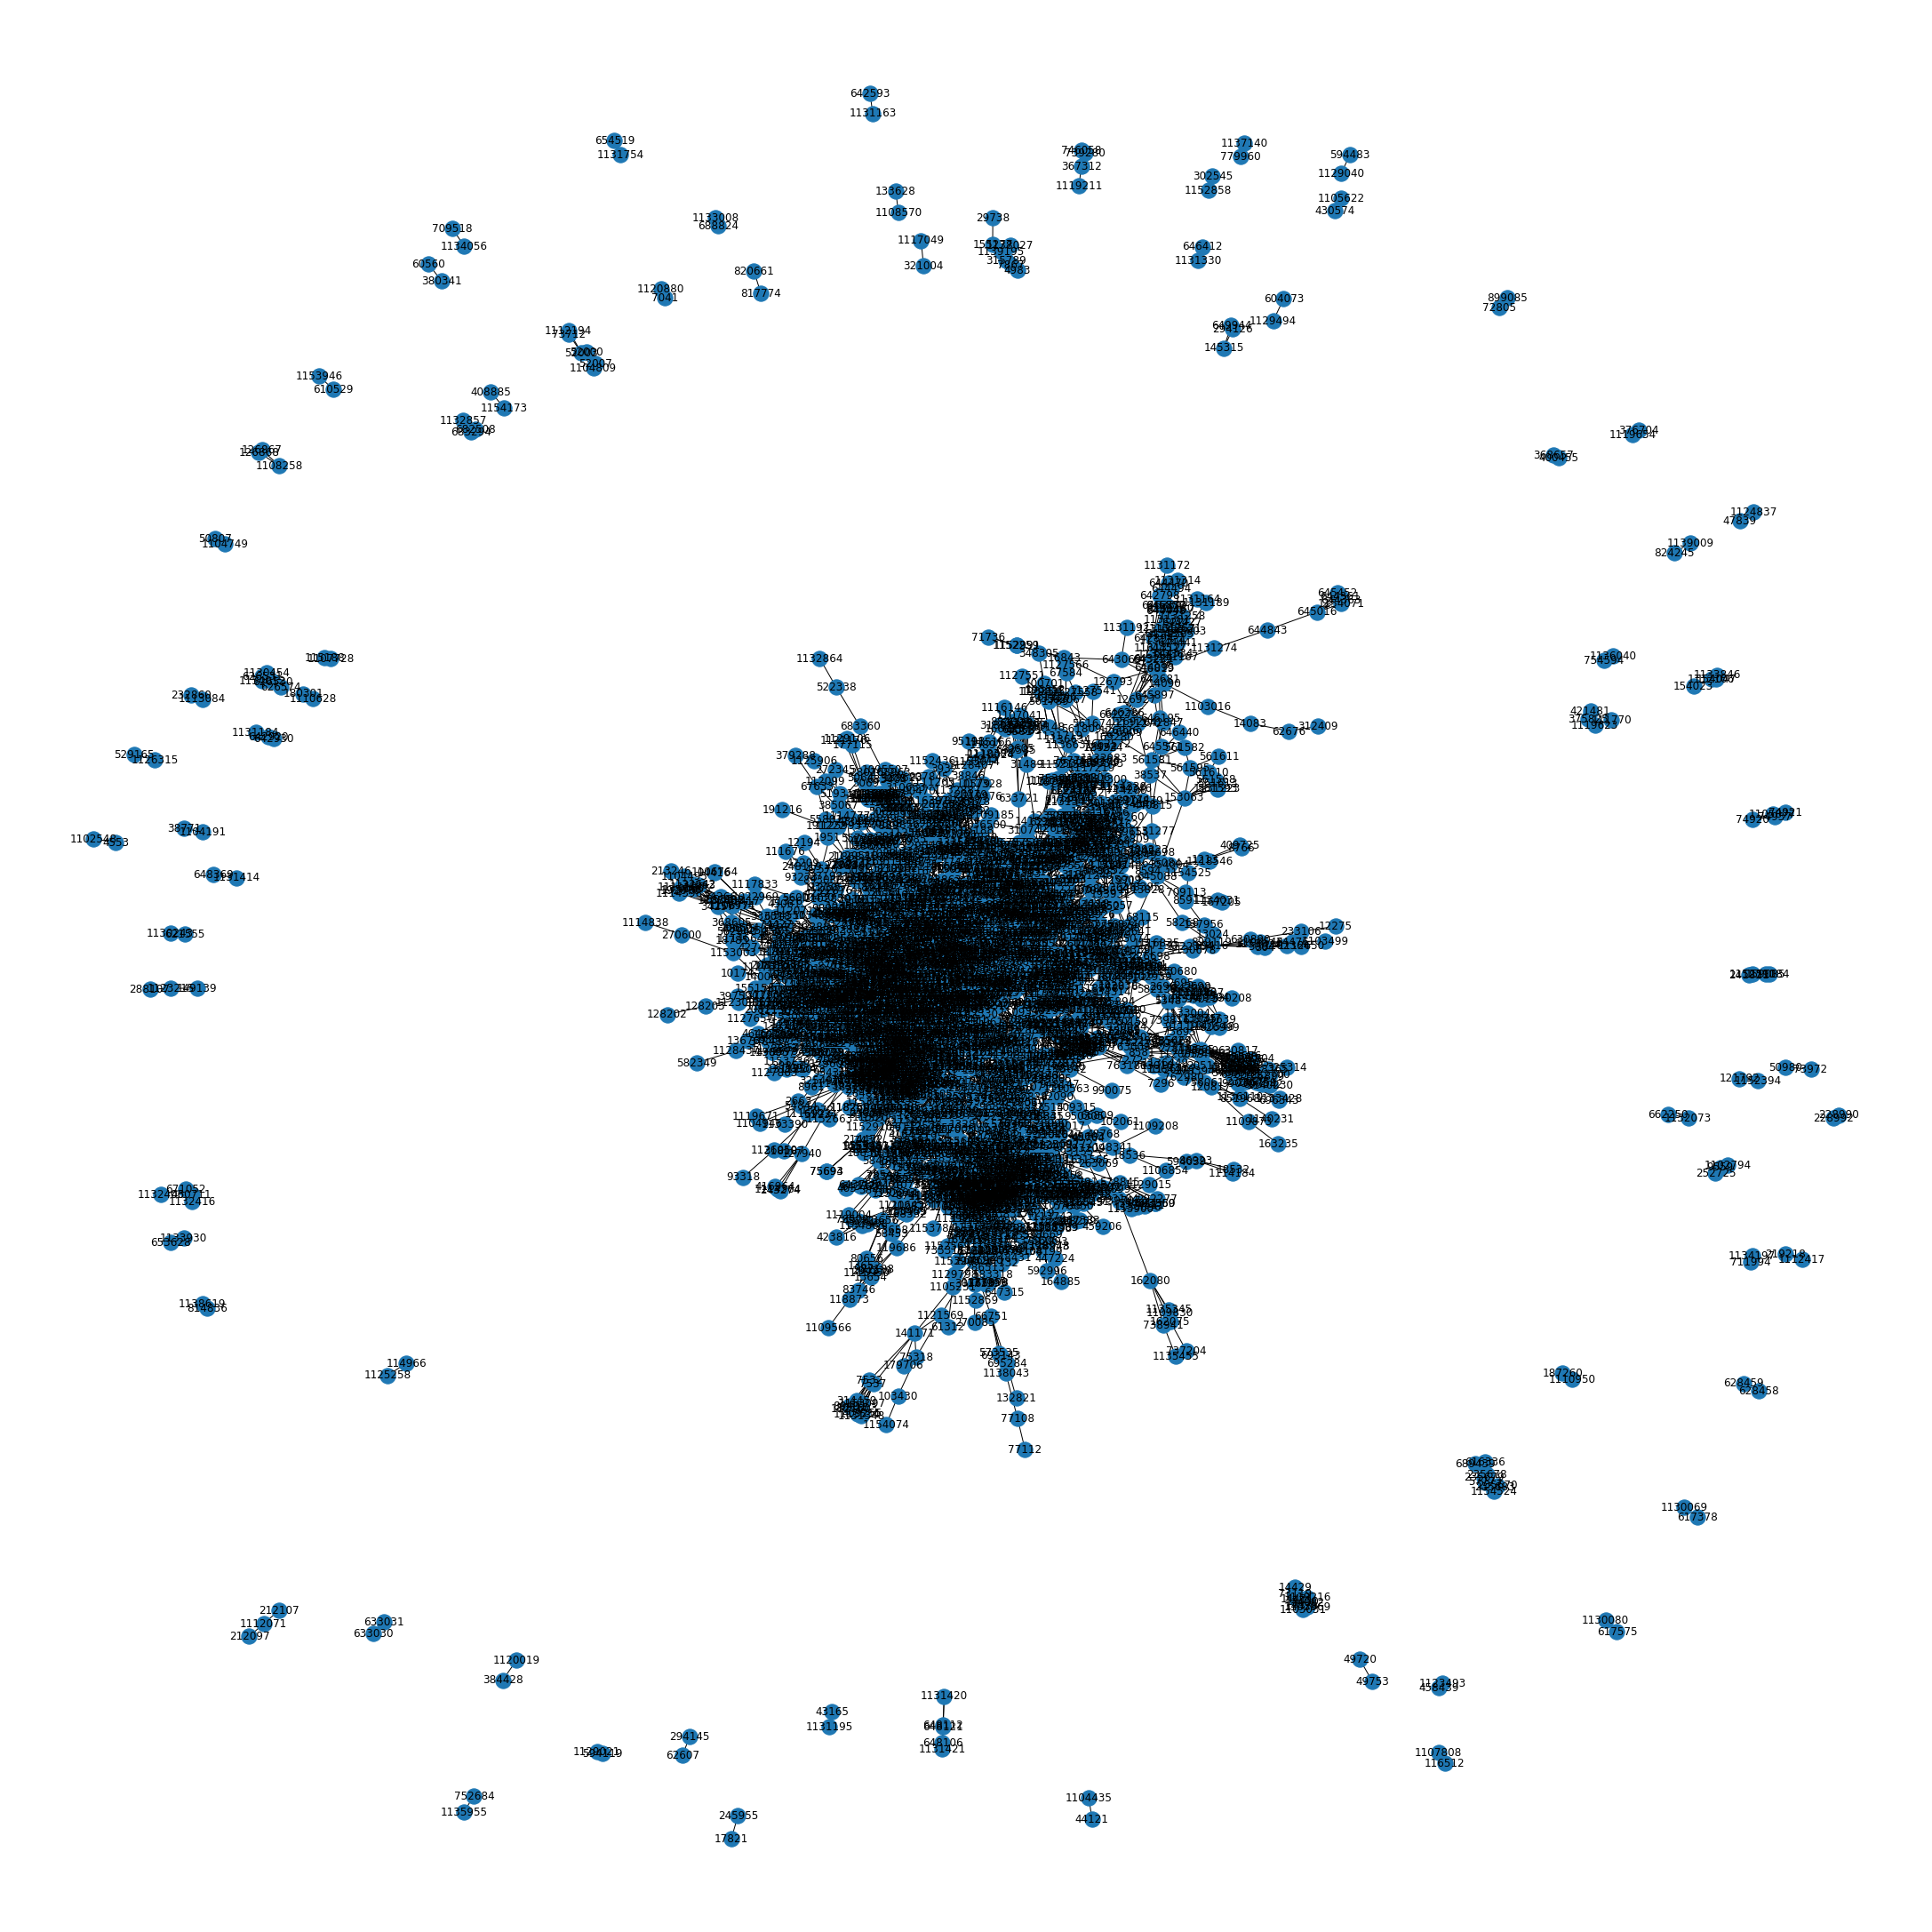

In [12]:
plt.figure(figsize=(30, 30))
nx.draw(G, with_labels=True)
plt.show()

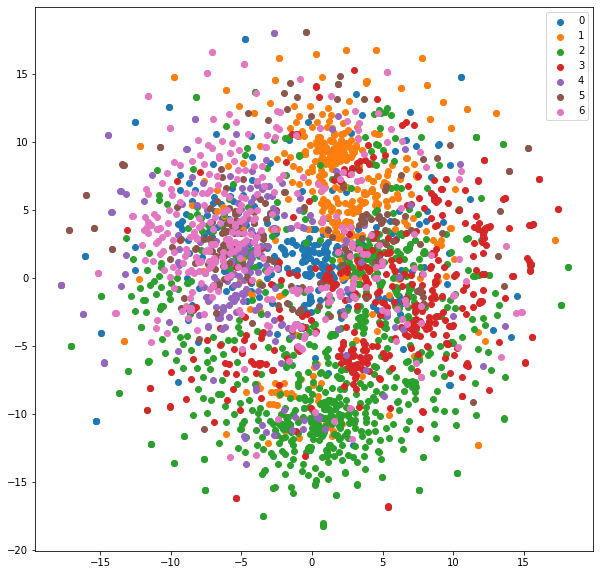

In [13]:
raw_x = TSNE(n_components=2).fit_transform(X)

plot_tSNE(labels_encoded, raw_x)

# DNN

#### Build Model 

In [14]:
DNN_model = DNN([128, 256], C.dropout)

DNN_model.compile(optimizer=Adam(1e-2),
           loss='categorical_crossentropy',
           weighted_metrics=['acc'])

#### Callbacks 

In [15]:
dnn_early_stop = EarlyStopping(patience=C.es_patience, restore_best_weights=True)

callbacks=[dnn_early_stop]

#### Make Valid data 

In [16]:
DNN_valid_data = (X, labels_encoded, val_mask)

#### Training 

Epoch 1/200
1/1 [==============================] - 1s 758ms/step - loss: 0.3035 - acc: 0.1357 - val_loss: 0.5046 - val_acc: 0.3100
Epoch 2/200
1/1 [==============================] - 0s 36ms/step - loss: 0.2463 - acc: 0.3429 - val_loss: 0.4615 - val_acc: 0.3580
Epoch 3/200
1/1 [==============================] - 0s 36ms/step - loss: 0.2017 - acc: 0.5643 - val_loss: 0.4281 - val_acc: 0.3780
Epoch 4/200
1/1 [==============================] - 0s 35ms/step - loss: 0.1687 - acc: 0.6000 - val_loss: 0.3973 - val_acc: 0.4520
Epoch 5/200
1/1 [==============================] - 0s 37ms/step - loss: 0.1384 - acc: 0.7429 - val_loss: 0.3661 - val_acc: 0.5120
Epoch 6/200
1/1 [==============================] - 0s 35ms/step - loss: 0.1136 - acc: 0.8429 - val_loss: 0.3345 - val_acc: 0.5300
Epoch 7/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0919 - acc: 0.9143 - val_loss: 0.3087 - val_acc: 0.5640
Epoch 8/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0799 - acc: 0.9

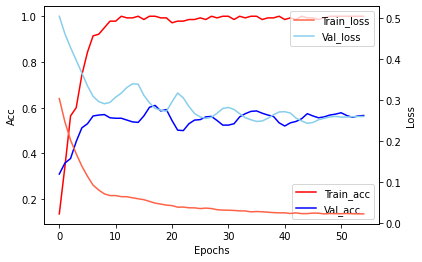

In [17]:
DNN_history = DNN_model.fit(X,
       labels_encoded,
       sample_weight=train_mask,
       epochs=C.epochs,
       batch_size=N,
       validation_data=DNN_valid_data,
       shuffle=False,
       callbacks=callbacks)

draw_history(DNN_history, 'DNN')

#### Evaluate 

In [18]:
X_te = X[test_mask]
y_te = labels_encoded[test_mask]

y_pred = DNN_model.predict(X_te, batch_size=N)

DNN_report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> DNN Classification Report:\n{DNN_report}')

LOG >>> DNN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.48      0.55      0.51       113
    Genetic_Algorithms       0.71      0.63      0.67       150
       Neural_Networks       0.64      0.58      0.61       306
 Probabilistic_Methods       0.55      0.54      0.54       167
Reinforcement_Learning       0.73      0.62      0.67        79
         Rule_Learning       0.29      0.65      0.40        62
                Theory       0.45      0.33      0.38       123

              accuracy                           0.55      1000
             macro avg       0.55      0.56      0.54      1000
          weighted avg       0.58      0.55      0.56      1000



#### Visualilzation 

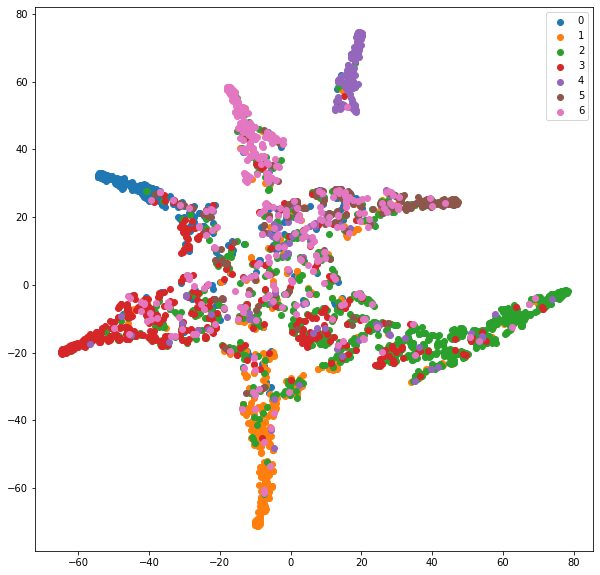

In [19]:
activations = DNN_model.predict(X)

dnn_x_tsne = TSNE(n_components=2).fit_transform(activations)
plot_tSNE(labels_encoded, dnn_x_tsne)

# DNN with metric learning

#### Build Model 

In [20]:
DNN_metric_model = DNN([128, 256], C.dropout)

DNN_metric_model.compile(optimizer=Adam(1e-2),
           loss=tfa.losses.TripletSemiHardLoss(),
            )

#### Callbacks

In [21]:
dnn_early_stop = EarlyStopping(patience=C.es_patience,
                               restore_best_weights=True,
                              monitor='loss')

callbacks=[dnn_early_stop]

#### Make Valid data

In [22]:
DNN_valid_data = (X, labels_encoded, val_mask)

#### Training

Epoch 1/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0179 - acc: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0162 - acc: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0143 - acc: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0125 - acc: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0108 - acc: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0080 - acc: 0.0000e+00
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0059 - acc: 0.0000e+00
Epoch 10/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - acc: 0.0000e+00
Epoch 11/200
1/1 [====================

1/1 [==============================] - 0s 2ms/step - loss: 3.3740e-06 - acc: 0.0000e+00
Epoch 82/200
1/1 [==============================] - 0s 1ms/step - loss: 3.0492e-06 - acc: 0.0000e+00
Epoch 83/200
1/1 [==============================] - 0s 1ms/step - loss: 2.7576e-06 - acc: 0.0000e+00
Epoch 84/200
1/1 [==============================] - 0s 1ms/step - loss: 2.4943e-06 - acc: 0.0000e+00
Epoch 85/200
1/1 [==============================] - 0s 1ms/step - loss: 2.2553e-06 - acc: 0.0000e+00
Epoch 86/200
1/1 [==============================] - 0s 1ms/step - loss: 2.0373e-06 - acc: 0.0000e+00
Epoch 87/200
1/1 [==============================] - 0s 2ms/step - loss: 1.8382e-06 - acc: 0.0000e+00
Epoch 88/200
1/1 [==============================] - 0s 2ms/step - loss: 1.6564e-06 - acc: 0.0000e+00
Epoch 89/200
1/1 [==============================] - 0s 2ms/step - loss: 1.4911e-06 - acc: 0.0000e+00
Epoch 90/200
1/1 [==============================] - 0s 2ms/step - loss: 1.3418e-06 - acc: 0.0000e+00
Epo

1/1 [==============================] - 0s 2ms/step - loss: 2.5057e-09 - acc: 0.0000e+00
Epoch 162/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8465e-09 - acc: 0.0000e+00
Epoch 163/200
1/1 [==============================] - 0s 2ms/step - loss: 3.4516e-09 - acc: 0.0000e+00
Epoch 164/200
1/1 [==============================] - 0s 2ms/step - loss: 3.6122e-09 - acc: 0.0000e+00
Epoch 165/200
1/1 [==============================] - 0s 1ms/step - loss: 3.1358e-09 - acc: 0.0000e+00
Epoch 166/200
1/1 [==============================] - 0s 2ms/step - loss: 2.5716e-09 - acc: 0.0000e+00
Epoch 167/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4335e-09 - acc: 0.0000e+00
Epoch 168/200
1/1 [==============================] - 0s 2ms/step - loss: 2.6407e-09 - acc: 0.0000e+00
Epoch 169/200
1/1 [==============================] - 0s 2ms/step - loss: 2.7103e-09 - acc: 0.0000e+00
Epoch 170/200
1/1 [==============================] - 0s 2ms/step - loss: 2.5157e-09 - acc: 0.000

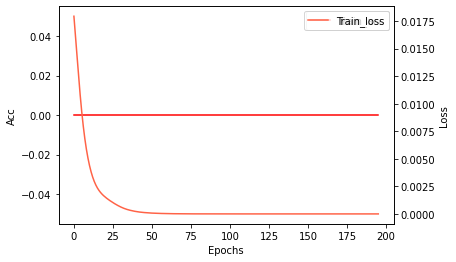

In [23]:
DNN_metric_history = DNN_model.fit(X[train_mask],
       epochs=C.epochs,
       batch_size=N,
       shuffle=False,
       callbacks=callbacks)

draw_history(DNN_metric_history, 'DNN_Metric')

#### Evaluate 

In [24]:
X_te = X[test_mask]
y_te = labels_encoded[test_mask]

y_pred = DNN_metric_model.predict(X_te, batch_size=N)

DNN_metric_report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> DNN Metric Classification Report:\n{DNN_metric_report}')

LOG >>> DNN Metric Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.10      0.03      0.04       113
    Genetic_Algorithms       0.19      0.19      0.19       150
       Neural_Networks       0.24      0.08      0.12       306
 Probabilistic_Methods       0.16      0.44      0.23       167
Reinforcement_Learning       0.02      0.03      0.02        79
         Rule_Learning       0.08      0.03      0.05        62
                Theory       0.08      0.09      0.08       123

              accuracy                           0.14      1000
             macro avg       0.12      0.13      0.10      1000
          weighted avg       0.16      0.14      0.12      1000



#### Visualization

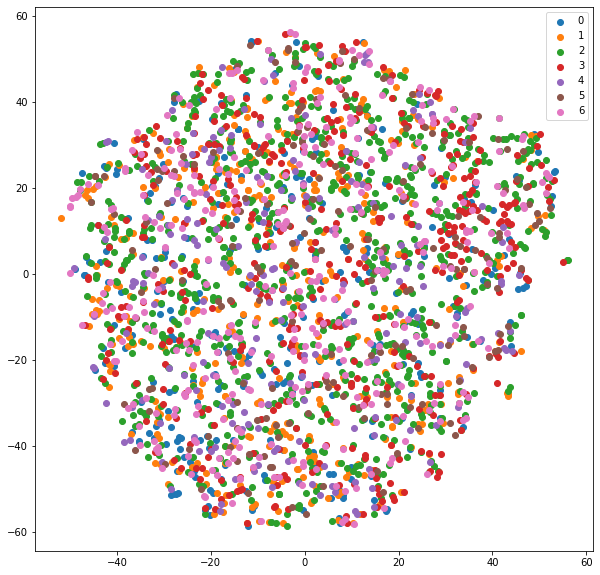

In [25]:
activations = DNN_metric_model.predict(X)

dnn_metric_x_tsne = TSNE(n_components=2).fit_transform(activations)
plot_tSNE(labels_encoded, dnn_metric_x_tsne)

# GCN

#### Build Model 

In [26]:
model = GCN(C.GCN_filters, C.dropout)

optimizer = Adam(lr=C.learning_rate)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Callbacks

In [27]:
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=C.LOG_PATH)
early_stop = tf.keras.callbacks.EarlyStopping(patience=C.es_patience, restore_best_weights=True)

# callbacks = [tensorboard, early_stop]
callbacks = [early_stop]

#### Make Valid data 

In [28]:
validation_data = ([A, X], labels_encoded, val_mask)

#### Training 

Epoch 1/200
1/1 [==============================] - 1s 665ms/step - loss: 0.1212 - acc: 0.1429 - val_loss: 0.3712 - val_acc: 0.2440
Epoch 2/200
1/1 [==============================] - 0s 109ms/step - loss: 0.1130 - acc: 0.3214 - val_loss: 0.3605 - val_acc: 0.3100
Epoch 3/200
1/1 [==============================] - 0s 108ms/step - loss: 0.1054 - acc: 0.4929 - val_loss: 0.3502 - val_acc: 0.3720
Epoch 4/200
1/1 [==============================] - 0s 108ms/step - loss: 0.1009 - acc: 0.5071 - val_loss: 0.3399 - val_acc: 0.4400
Epoch 5/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0950 - acc: 0.6357 - val_loss: 0.3304 - val_acc: 0.4840
Epoch 6/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0918 - acc: 0.6571 - val_loss: 0.3209 - val_acc: 0.5220
Epoch 7/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0895 - acc: 0.7643 - val_loss: 0.3120 - val_acc: 0.5900
Epoch 8/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0847 - a

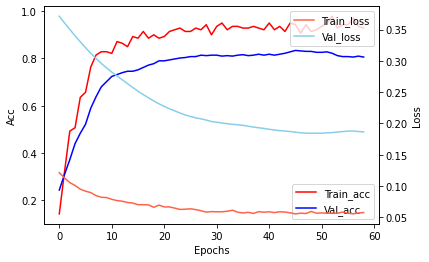

In [29]:
history = model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'GCN')

#### Evaluate 

In [30]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.77      0.72      0.74       113
    Genetic_Algorithms       0.85      0.81      0.83       150
       Neural_Networks       0.85      0.75      0.80       306
 Probabilistic_Methods       0.82      0.81      0.81       167
Reinforcement_Learning       0.76      0.78      0.77        79
         Rule_Learning       0.53      0.79      0.64        62
                Theory       0.56      0.65      0.60       123

              accuracy                           0.76      1000
             macro avg       0.73      0.76      0.74      1000
          weighted avg       0.77      0.76      0.76      1000



####  Visualization

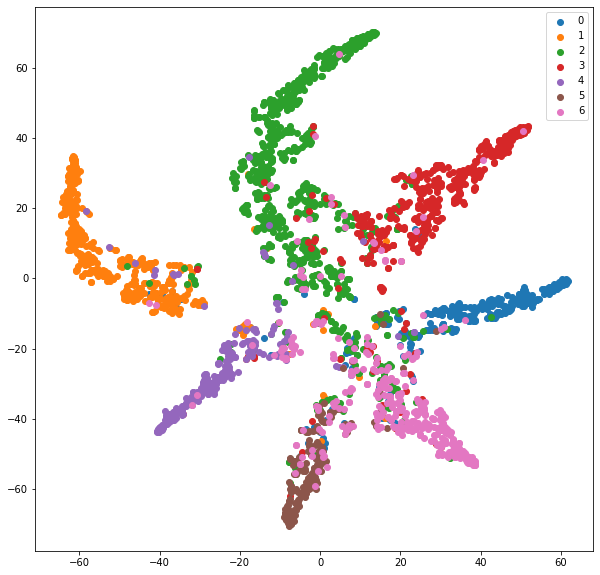

In [31]:
activations = model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# Inception GCN

#### Build Model

In [32]:
inception_GCN_model = InceptionGCN(C.dropout)

optimizer = Adam(lr=C.learning_rate)
inception_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.1628 - acc: 0.1286 - val_loss: 0.4020 - val_acc: 0.1300
Epoch 2/200
1/1 [==============================] - 0s 487ms/step - loss: 0.1442 - acc: 0.1429 - val_loss: 0.3880 - val_acc: 0.1540
Epoch 3/200
1/1 [==============================] - 0s 484ms/step - loss: 0.1304 - acc: 0.2071 - val_loss: 0.3787 - val_acc: 0.1460
Epoch 4/200
1/1 [==============================] - 0s 487ms/step - loss: 0.1212 - acc: 0.2571 - val_loss: 0.3727 - val_acc: 0.1800
Epoch 5/200
1/1 [==============================] - 0s 488ms/step - loss: 0.1156 - acc: 0.3286 - val_loss: 0.3689 - val_acc: 0.2100
Epoch 6/200
1/1 [==============================] - 0s 484ms/step - loss: 0.1126 - acc: 0.3429 - val_loss: 0.3669 - val_acc: 0.2200
Epoch 7/200
1/1 [==============================] - 0s 485ms/step - loss: 0.1116 - acc: 0.3357 - val_loss: 0.3662 - val_acc: 0.2300
Epoch 8/200
1/1 [==============================] - 0s 489ms/step - loss: 0.1116 - acc:

1/1 [==============================] - 0s 484ms/step - loss: 0.0990 - acc: 0.7000 - val_loss: 0.3409 - val_acc: 0.6180
Epoch 64/200
1/1 [==============================] - 0s 481ms/step - loss: 0.0998 - acc: 0.6929 - val_loss: 0.3401 - val_acc: 0.6220
Epoch 65/200
1/1 [==============================] - 0s 482ms/step - loss: 0.0982 - acc: 0.7000 - val_loss: 0.3393 - val_acc: 0.6180
Epoch 66/200
1/1 [==============================] - 0s 482ms/step - loss: 0.0981 - acc: 0.7071 - val_loss: 0.3382 - val_acc: 0.6260
Epoch 67/200
1/1 [==============================] - 0s 483ms/step - loss: 0.0985 - acc: 0.6857 - val_loss: 0.3370 - val_acc: 0.6360
Epoch 68/200
1/1 [==============================] - 0s 484ms/step - loss: 0.0992 - acc: 0.6714 - val_loss: 0.3358 - val_acc: 0.6440
Epoch 69/200
1/1 [==============================] - 0s 482ms/step - loss: 0.0986 - acc: 0.7071 - val_loss: 0.3348 - val_acc: 0.6520
Epoch 70/200
1/1 [==============================] - 0s 483ms/step - loss: 0.0987 - acc: 0

Epoch 125/200
1/1 [==============================] - 0s 483ms/step - loss: 0.0965 - acc: 0.8571 - val_loss: 0.2983 - val_acc: 0.7440
Epoch 126/200
1/1 [==============================] - 0s 484ms/step - loss: 0.0959 - acc: 0.7929 - val_loss: 0.2987 - val_acc: 0.7360
Epoch 127/200
1/1 [==============================] - 0s 487ms/step - loss: 0.0974 - acc: 0.8429 - val_loss: 0.2988 - val_acc: 0.7440
Epoch 128/200
1/1 [==============================] - 0s 486ms/step - loss: 0.0967 - acc: 0.8071 - val_loss: 0.2985 - val_acc: 0.7560
Epoch 129/200
1/1 [==============================] - 0s 484ms/step - loss: 0.0983 - acc: 0.8214 - val_loss: 0.2985 - val_acc: 0.7600
Epoch 130/200
1/1 [==============================] - 0s 481ms/step - loss: 0.0960 - acc: 0.8286 - val_loss: 0.2987 - val_acc: 0.7600
Epoch 131/200
1/1 [==============================] - 0s 491ms/step - loss: 0.0960 - acc: 0.8071 - val_loss: 0.2995 - val_acc: 0.7600
Epoch 132/200
1/1 [==============================] - 0s 484ms/step - 

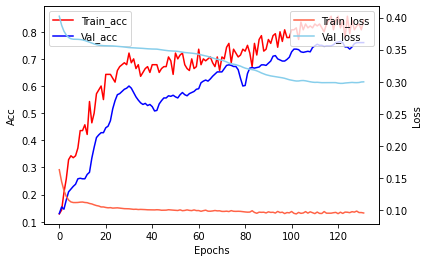

In [33]:
history = inception_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'Inception GCN', issave=True)

#### Evaluate

In [34]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = inception_GCN_model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Inception GCN Classification Report:\n{report}')

LOG >>> Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.72      0.81      0.77       113
    Genetic_Algorithms       0.86      0.83      0.84       150
       Neural_Networks       0.91      0.51      0.65       306
 Probabilistic_Methods       0.66      0.82      0.73       167
Reinforcement_Learning       0.57      0.86      0.68        79
         Rule_Learning       0.54      0.81      0.65        62
                Theory       0.57      0.63      0.60       123

              accuracy                           0.70      1000
             macro avg       0.69      0.75      0.70      1000
          weighted avg       0.75      0.70      0.70      1000



#### Visualization

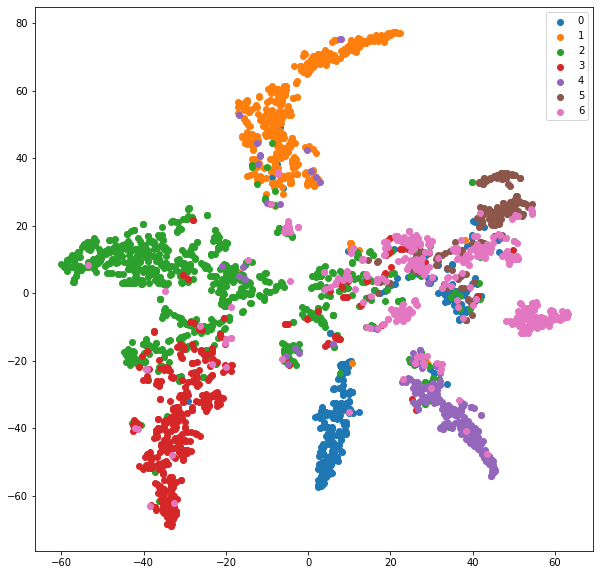

In [35]:
activations = inception_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# Residual GCN

#### Build Model 

In [36]:
residual_GCN_model = ResidualGCN(C.dropout)

optimizer = Adam(lr=C.learning_rate)
residual_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

Epoch 1/200
1/1 [==============================] - 1s 813ms/step - loss: 0.1219 - acc: 0.1643 - val_loss: 0.3607 - val_acc: 0.2820
Epoch 2/200
1/1 [==============================] - 0s 109ms/step - loss: 0.1101 - acc: 0.3000 - val_loss: 0.3403 - val_acc: 0.4140
Epoch 3/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0978 - acc: 0.5000 - val_loss: 0.3203 - val_acc: 0.5240
Epoch 4/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0899 - acc: 0.5571 - val_loss: 0.2999 - val_acc: 0.5960
Epoch 5/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0784 - acc: 0.6214 - val_loss: 0.2798 - val_acc: 0.6500
Epoch 6/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0740 - acc: 0.6643 - val_loss: 0.2604 - val_acc: 0.6900
Epoch 7/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0675 - acc: 0.6786 - val_loss: 0.2441 - val_acc: 0.7040
Epoch 8/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0590 - a

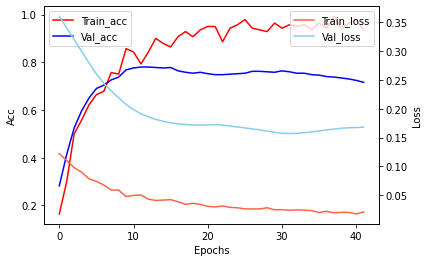

In [37]:
history = residual_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'Residual GCN', issave=True)

#### Evaluate

In [38]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = residual_GCN_model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Residual GCN Classification Report:\n{report}')

LOG >>> Residual GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.72      0.63      0.67       113
    Genetic_Algorithms       0.87      0.69      0.77       150
       Neural_Networks       0.73      0.67      0.70       306
 Probabilistic_Methods       0.76      0.60      0.67       167
Reinforcement_Learning       0.68      0.68      0.68        79
         Rule_Learning       0.37      0.85      0.52        62
                Theory       0.47      0.57      0.52       123

              accuracy                           0.66      1000
             macro avg       0.66      0.67      0.65      1000
          weighted avg       0.70      0.66      0.67      1000



#### Visualization

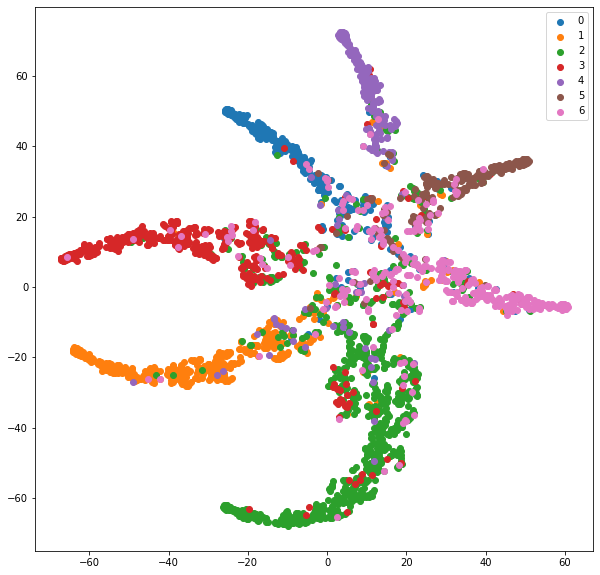

In [39]:
activations = residual_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# Gated Skip Connection GCN

#### Build Model

In [40]:
gated_skip_connection_GCN_model = GatedSkipConnectionGCN(C.dropout)

optimizer = Adam(lr=C.learning_rate)
gated_skip_connection_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

Epoch 1/200
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
1/1 [==============================] - 1s 1s/step - loss: 5.5369 - acc: 0.1571 - val_loss: 2.5342 - val_acc: 0.1500
Epoch 2/200
1/1 [==============================] - 0s 218ms/step - loss: 2.2742 - acc: 0.1857 - val_loss: 0.9847 - val_acc: 0.2300
Epoch 3/200
1/1 [==============================] - 0s 214ms/step - loss: 0.7247 - acc: 0.3857 - val_loss: 0.6683 - val_acc: 0.3040
Epoch 4/200
1/1 [==============================] - 0s 219ms/step - loss: 0.4089 - acc: 0.5000 - val_loss: 0.9559 - val_acc: 0.3260
Epoch 5/200
1/1 [==============================] - 0s 213ms/step - loss: 0.6941 - acc: 0.6857 - val_loss: 1.3433 - val_acc: 0.3440
Epoch 6/200
1/1 [==============================] - 0s 211ms/step - loss: 1.0788 - acc: 0.6786 - val_loss: 1.5522 - val_acc: 0.3500
Epoch 7/200
1/1 [==============================] - 0s 216ms/step - 

1/1 [==============================] - 0s 212ms/step - loss: 0.1303 - acc: 0.9214 - val_loss: 0.4144 - val_acc: 0.4200
Epoch 63/200
1/1 [==============================] - 0s 213ms/step - loss: 0.1286 - acc: 0.9429 - val_loss: 0.4165 - val_acc: 0.4120
Epoch 64/200
1/1 [==============================] - 0s 216ms/step - loss: 0.1302 - acc: 0.9571 - val_loss: 0.4189 - val_acc: 0.4160
Epoch 65/200
1/1 [==============================] - 0s 214ms/step - loss: 0.1335 - acc: 0.9000 - val_loss: 0.4209 - val_acc: 0.4220
Epoch 66/200
1/1 [==============================] - 0s 216ms/step - loss: 0.1317 - acc: 0.9143 - val_loss: 0.4189 - val_acc: 0.4320
Epoch 67/200
1/1 [==============================] - 0s 213ms/step - loss: 0.1304 - acc: 0.9643 - val_loss: 0.4119 - val_acc: 0.4440
Epoch 68/200
1/1 [==============================] - 0s 215ms/step - loss: 0.1273 - acc: 0.9286 - val_loss: 0.4041 - val_acc: 0.4420
Epoch 69/200
1/1 [==============================] - 0s 216ms/step - loss: 0.1216 - acc: 0

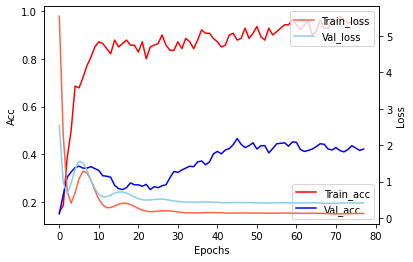

In [41]:
history = gated_skip_connection_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'GatedSkipConnection GCN', issave=True)

#### Evaluate

In [42]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

# y_pred = gated_skip_connection_GCN_model.predict([A_te, X_te], batch_size=N)
gated_skip_connection_GCN_model.predict([A, X], batch_size=N)[test_mask]
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GatedSkipConnection GCN Classification Report:\n{report}')

LOG >>> GatedSkipConnection GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.72      0.63      0.67       113
    Genetic_Algorithms       0.87      0.69      0.77       150
       Neural_Networks       0.73      0.67      0.70       306
 Probabilistic_Methods       0.76      0.60      0.67       167
Reinforcement_Learning       0.68      0.68      0.68        79
         Rule_Learning       0.37      0.85      0.52        62
                Theory       0.47      0.57      0.52       123

              accuracy                           0.66      1000
             macro avg       0.66      0.67      0.65      1000
          weighted avg       0.70      0.66      0.67      1000



#### Visualization

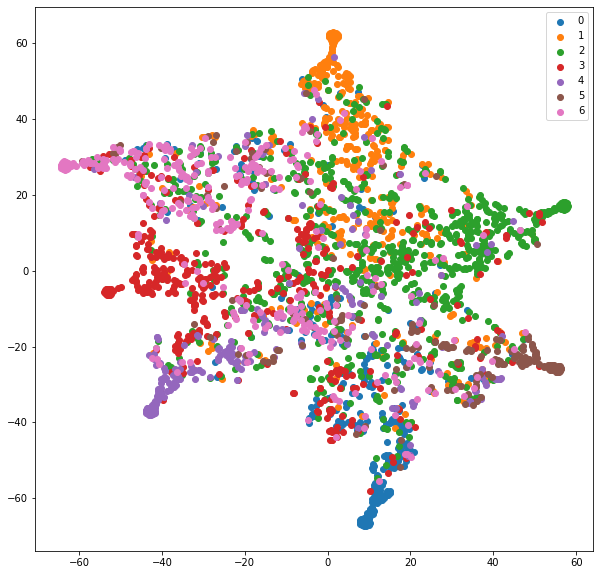

In [43]:
activations = gated_skip_connection_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# AttentionGCN

In [44]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 num_head,
                 activation=None,
                 bn=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None):
        super(Attention, self).__init__()
        self.filters = filters
        self.num_head = num_head
        self.attention_filters = filters // num_head
        self.activation = activation
        self.use_bn = bn
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_initializer = bias_initializer
        self.bias_regularizer = bias_regularizer
        self.BatchNorm = tf.keras.layers.BatchNormalization()
        
    def build(self, input_shape):
        self.weight = self.add_weight(name='weight',
                                       shape=[input_shape[1][-1], self.attention_filters],
                                       initializer=self.kernel_initializer,
                                       regularizer=self.kernel_regularizer,
                                       trainable=True)
        
        self.correlation_list = []
        for i in range(self.num_head):
            corr = self.add_weight(name=f'correlation_{i}',
                                   shape=[self.attention_filters, self.attention_filters],
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   trainable=True)
            self.correlation_list.append(corr)
        
    def call(self, inputs):
        # A = inputs[0]
        # x = inputs[1]
        outputs = []
        x = tf.matmul(inputs[0], inputs[1])
        x = tf.matmul(x, self.weight)
        for i in range(self.num_head):
            a = self.get_attention(x, i)
            outputs.append(tf.matmul(a, x))
        output = tf.concat(outputs, axis=-1)
            
        if self.use_bn:
            output = self.BatchNorm(output)
        if self.activation:
            output = self.activation(output)
        return [inputs[0], output]
    
    def get_attention(self, x, i):
        f = tf.matmul(x, self.correlation_list[i])
        output = tf.matmul(f, tf.transpose(x))
        output = tf.nn.tanh(output)
        return output

In [45]:
class AttentionGCN(tf.keras.Model):
    def __init__(self, dropout):
        super(AttentionGCN, self).__init__(name='AttentionGCN')
        
        self.dropout_1 = Dropout(dropout)
        self.attention_1 = Attention(filters=C.GCN_filters, bn=True, num_head=4, activation=tf.nn.relu)
        self.dropout_2 = Dropout(dropout)
        self.attention_2 = Attention(filters=C.num_classes, bn=True, num_head=C.num_classes, activation=tf.nn.softmax)
        
    def call(self, input_tensor, training=False):
        A, x = input_tensor
        x = self.dropout_1(x)
        A, x = self.attention_1([A, x])
        x = self.dropout_2(x)
        A, x = self.attention_2([A, x])
        return x

#### Build Model

In [46]:
attention_GCN_model = AttentionGCN(C.dropout)

optimizer = Adam(lr=C.learning_rate)
attention_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.1214 - acc: 0.1214 - val_loss: 11.6424 - val_acc: 0.0880
Epoch 2/500
1/1 [==============================] - 0s 289ms/step - loss: 0.1051 - acc: 0.2000 - val_loss: 7.3206 - val_acc: 0.1080
Epoch 3/500
1/1 [==============================] - 0s 290ms/step - loss: 0.0949 - acc: 0.2214 - val_loss: 20.9190 - val_acc: 0.1100
Epoch 4/500
1/1 [==============================] - 0s 287ms/step - loss: 0.0896 - acc: 0.2071 - val_loss: 34.8425 - val_acc: 0.1200
Epoch 5/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0821 - acc: 0.2643 - val_loss: 31.5391 - val_acc: 0.1120
Epoch 6/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0759 - acc: 0.3071 - val_loss: 29.2742 - val_acc: 0.1120
Epoch 7/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0783 - acc: 0.2643 - val_loss: 26.8811 - val_acc: 0.0860
Epoch 8/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0753 

1/1 [==============================] - 0s 296ms/step - loss: 0.0901 - acc: 0.2786 - val_loss: 2.2685 - val_acc: 0.1320
Epoch 64/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0901 - acc: 0.2929 - val_loss: 2.4257 - val_acc: 0.1380
Epoch 65/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0867 - acc: 0.2571 - val_loss: 2.5764 - val_acc: 0.0740
Epoch 66/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0863 - acc: 0.2571 - val_loss: 2.6810 - val_acc: 0.0700
Epoch 67/500
1/1 [==============================] - 0s 280ms/step - loss: 0.0865 - acc: 0.2786 - val_loss: 2.7636 - val_acc: 0.0580
Epoch 68/500
1/1 [==============================] - 0s 278ms/step - loss: 0.0858 - acc: 0.3000 - val_loss: 2.7968 - val_acc: 0.0580
Epoch 69/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0854 - acc: 0.2786 - val_loss: 2.7212 - val_acc: 0.0600
Epoch 70/500
1/1 [==============================] - 0s 287ms/step - loss: 0.0845 - acc: 0

Epoch 125/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0740 - acc: 0.3000 - val_loss: 0.6001 - val_acc: 0.1880
Epoch 126/500
1/1 [==============================] - 0s 287ms/step - loss: 0.0741 - acc: 0.3214 - val_loss: 0.5875 - val_acc: 0.1940
Epoch 127/500
1/1 [==============================] - 0s 285ms/step - loss: 0.0738 - acc: 0.3000 - val_loss: 0.5749 - val_acc: 0.2000
Epoch 128/500
1/1 [==============================] - 0s 290ms/step - loss: 0.0735 - acc: 0.3429 - val_loss: 0.5642 - val_acc: 0.1900
Epoch 129/500
1/1 [==============================] - 0s 285ms/step - loss: 0.0738 - acc: 0.2929 - val_loss: 0.5552 - val_acc: 0.1880
Epoch 130/500
1/1 [==============================] - 0s 289ms/step - loss: 0.0738 - acc: 0.3071 - val_loss: 0.5457 - val_acc: 0.1960
Epoch 131/500
1/1 [==============================] - 0s 300ms/step - loss: 0.0735 - acc: 0.3214 - val_loss: 0.5388 - val_acc: 0.1920
Epoch 132/500
1/1 [==============================] - 0s 288ms/step - 

1/1 [==============================] - 0s 284ms/step - loss: 0.0665 - acc: 0.5000 - val_loss: 0.3507 - val_acc: 0.3260
Epoch 187/500
1/1 [==============================] - 0s 283ms/step - loss: 0.0665 - acc: 0.5286 - val_loss: 0.3551 - val_acc: 0.3200
Epoch 188/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0644 - acc: 0.4786 - val_loss: 0.3550 - val_acc: 0.2880
Epoch 189/500
1/1 [==============================] - 0s 285ms/step - loss: 0.0898 - acc: 0.4571 - val_loss: 0.3631 - val_acc: 0.2860
Epoch 190/500
1/1 [==============================] - 0s 287ms/step - loss: 0.0903 - acc: 0.4500 - val_loss: 0.3751 - val_acc: 0.2880
Epoch 191/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0847 - acc: 0.4286 - val_loss: 0.3957 - val_acc: 0.2480
Epoch 192/500
1/1 [==============================] - 0s 281ms/step - loss: 0.0841 - acc: 0.4643 - val_loss: 0.4271 - val_acc: 0.2280
Epoch 193/500
1/1 [==============================] - 0s 287ms/step - loss: 0.0822 -

Epoch 248/500
1/1 [==============================] - 0s 297ms/step - loss: 0.0554 - acc: 0.5857 - val_loss: 0.4419 - val_acc: 0.2180
Epoch 249/500
1/1 [==============================] - 0s 283ms/step - loss: 0.0785 - acc: 0.5286 - val_loss: 0.4576 - val_acc: 0.2180
Epoch 250/500
1/1 [==============================] - 0s 297ms/step - loss: 0.0795 - acc: 0.5214 - val_loss: 0.4749 - val_acc: 0.2300
Epoch 251/500
1/1 [==============================] - 0s 299ms/step - loss: 0.0771 - acc: 0.5357 - val_loss: 0.5023 - val_acc: 0.2360
Epoch 252/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0768 - acc: 0.5071 - val_loss: 0.5388 - val_acc: 0.2440
Epoch 253/500
1/1 [==============================] - 0s 287ms/step - loss: 0.0743 - acc: 0.5357 - val_loss: 0.5739 - val_acc: 0.2460
Epoch 254/500
1/1 [==============================] - 0s 285ms/step - loss: 0.0707 - acc: 0.5714 - val_loss: 0.6140 - val_acc: 0.2420
Epoch 255/500
1/1 [==============================] - 0s 283ms/step - 

1/1 [==============================] - 0s 292ms/step - loss: 0.0530 - acc: 0.5286 - val_loss: 1.0223 - val_acc: 0.2160
Epoch 310/500
1/1 [==============================] - 0s 280ms/step - loss: 0.0552 - acc: 0.5429 - val_loss: 1.0159 - val_acc: 0.2240
Epoch 311/500
1/1 [==============================] - 0s 283ms/step - loss: 0.0513 - acc: 0.5714 - val_loss: 0.9991 - val_acc: 0.2280
Epoch 312/500
1/1 [==============================] - 0s 283ms/step - loss: 0.0528 - acc: 0.5571 - val_loss: 0.9769 - val_acc: 0.2300
Epoch 313/500
1/1 [==============================] - 0s 281ms/step - loss: 0.0520 - acc: 0.5857 - val_loss: 0.9524 - val_acc: 0.2440
Epoch 314/500
1/1 [==============================] - 0s 290ms/step - loss: 0.0515 - acc: 0.5714 - val_loss: 0.9352 - val_acc: 0.2440
Epoch 315/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0541 - acc: 0.5714 - val_loss: 0.9050 - val_acc: 0.2520
Epoch 316/500
1/1 [==============================] - 0s 291ms/step - loss: 0.0532 -

Epoch 371/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0492 - acc: 0.5571 - val_loss: 0.8581 - val_acc: 0.2220
Epoch 372/500
1/1 [==============================] - 0s 281ms/step - loss: 0.0480 - acc: 0.5571 - val_loss: 0.8474 - val_acc: 0.2300
Epoch 373/500
1/1 [==============================] - 0s 283ms/step - loss: 0.0496 - acc: 0.5500 - val_loss: 0.8443 - val_acc: 0.2400
Epoch 374/500
1/1 [==============================] - 0s 289ms/step - loss: 0.0480 - acc: 0.5643 - val_loss: 0.8472 - val_acc: 0.2460
Epoch 375/500
1/1 [==============================] - 0s 280ms/step - loss: 0.0480 - acc: 0.5571 - val_loss: 0.8496 - val_acc: 0.2460
Epoch 376/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0505 - acc: 0.5571 - val_loss: 0.8436 - val_acc: 0.2420
Epoch 377/500
1/1 [==============================] - 0s 281ms/step - loss: 0.0474 - acc: 0.5857 - val_loss: 0.8421 - val_acc: 0.2420
Epoch 378/500
1/1 [==============================] - 0s 286ms/step - 

1/1 [==============================] - 0s 285ms/step - loss: 0.0517 - acc: 0.5643 - val_loss: 0.7139 - val_acc: 0.2660
Epoch 433/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0464 - acc: 0.5571 - val_loss: 0.7142 - val_acc: 0.2680
Epoch 434/500
1/1 [==============================] - 0s 278ms/step - loss: 0.0466 - acc: 0.5714 - val_loss: 0.7146 - val_acc: 0.2720
Epoch 435/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0463 - acc: 0.5429 - val_loss: 0.7180 - val_acc: 0.2760
Epoch 436/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0463 - acc: 0.5429 - val_loss: 0.7235 - val_acc: 0.2800
Epoch 437/500
1/1 [==============================] - 0s 283ms/step - loss: 0.0486 - acc: 0.5643 - val_loss: 0.7232 - val_acc: 0.2840
Epoch 438/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0466 - acc: 0.5500 - val_loss: 0.7265 - val_acc: 0.2880
Epoch 439/500
1/1 [==============================] - 0s 289ms/step - loss: 0.0464 -

Epoch 494/500
1/1 [==============================] - 0s 279ms/step - loss: 0.0472 - acc: 0.5571 - val_loss: 0.6936 - val_acc: 0.2740
Epoch 495/500
1/1 [==============================] - 0s 280ms/step - loss: 0.0486 - acc: 0.5286 - val_loss: 0.7060 - val_acc: 0.2800
Epoch 496/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0470 - acc: 0.5857 - val_loss: 0.7132 - val_acc: 0.2800
Epoch 497/500
1/1 [==============================] - 0s 278ms/step - loss: 0.0463 - acc: 0.5571 - val_loss: 0.7079 - val_acc: 0.2780
Epoch 498/500
1/1 [==============================] - 0s 277ms/step - loss: 0.0473 - acc: 0.5571 - val_loss: 0.7087 - val_acc: 0.2760
Epoch 499/500
1/1 [==============================] - 0s 278ms/step - loss: 0.0505 - acc: 0.5429 - val_loss: 0.7052 - val_acc: 0.2760
Epoch 500/500
1/1 [==============================] - 0s 275ms/step - loss: 0.0452 - acc: 0.5714 - val_loss: 0.7025 - val_acc: 0.2780
LOG >>> Graph is saved


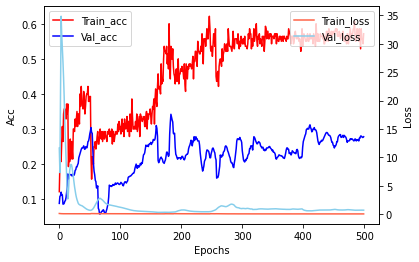

In [47]:
# history = attention_GCN_model.fit([A, X],
#          labels_encoded,
#          sample_weight=train_mask,
#          epochs=C.epochs,
#          batch_size=N,
#          validation_data=validation_data,
#          shuffle=False,
#          callbacks=callbacks)
history = attention_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=500,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
)

draw_history(history, 'Attention GCN', issave=True)

#### Evaluate

In [48]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = attention_GCN_model.predict([A_te, X_te], batch_size=N)
# attention_GCN_model.predict([A, X], batch_size=N)[test_mask]
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Attention GCN Classification Report:\n{report}')

LOG >>> Attention GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.00      0.00      0.00       113
    Genetic_Algorithms       0.00      0.00      0.00       150
       Neural_Networks       0.00      0.00      0.00       306
 Probabilistic_Methods       0.00      0.00      0.00       167
Reinforcement_Learning       0.08      1.00      0.15        79
         Rule_Learning       0.00      0.00      0.00        62
                Theory       0.00      0.00      0.00       123

              accuracy                           0.08      1000
             macro avg       0.01      0.14      0.02      1000
          weighted avg       0.01      0.08      0.01      1000



/home/sungjin/anaconda3/envs/GCN/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Visualization

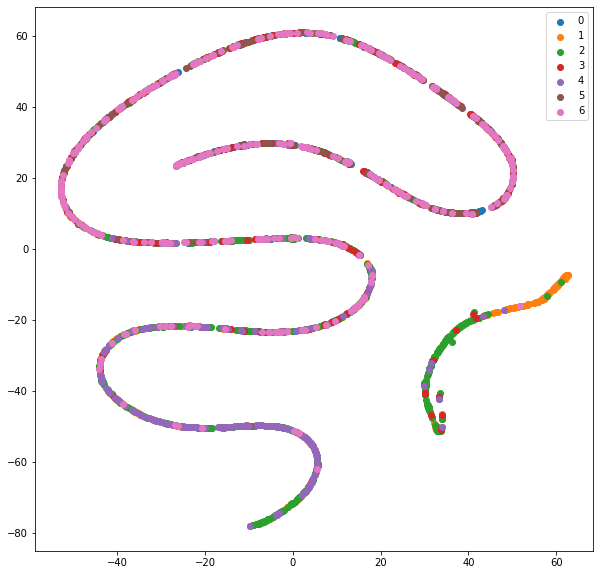

In [49]:
activations = attention_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# Others

## Inception + residual

#### Build Model 

In [50]:
residual_inception_GCN_model = GatedSkipConnectionGCN(C.dropout, inception=True, isgate=False)

optimizer = Adam(lr=C.learning_rate)
residual_inception_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

Epoch 1/200
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
1/1 [==============================] - 1s 1s/step - loss: 5.5806 - acc: 0.1500 - val_loss: 2.5546 - val_acc: 0.2460
Epoch 2/200
1/1 [==============================] - 1s 544ms/step - loss: 2.3012 - acc: 0.2071 - val_loss: 0.9910 - val_acc: 0.3040
Epoch 3/200
1/1 [==============================] - 1s 545ms/step - loss: 0.7409 - acc: 0.3071 - val_loss: 0.6630 - val_acc: 0.3880
Epoch 4/200
1/1 [==============================] - 1s 545ms/step - loss: 0.4156 - acc: 0.4286 - val_loss: 0.9402 - val_acc: 0.4600
Epoch 5/200
1/1 [==============================] - 1s 549ms/step - loss: 0.6949 - acc: 0.4143 - val_loss: 1.3165 - val_acc: 0.5040
Epoch 6/200
1/1 [==============================] - 1s 545ms/step - loss: 1.0792 - acc: 0.5000 - val_loss: 1.5135 - val_acc: 0.5360
Epoch 7/200
1/1 [==============================] - 1s 546ms/step - 

Epoch 57/200
1/1 [==============================] - 1s 546ms/step - loss: 0.0261 - acc: 0.9000 - val_loss: 0.2205 - val_acc: 0.6220
Epoch 58/200
1/1 [==============================] - 1s 549ms/step - loss: 0.0236 - acc: 0.9143 - val_loss: 0.2213 - val_acc: 0.6220
Epoch 59/200
1/1 [==============================] - 1s 547ms/step - loss: 0.0210 - acc: 0.9500 - val_loss: 0.2202 - val_acc: 0.6240
Epoch 60/200
1/1 [==============================] - 1s 546ms/step - loss: 0.0215 - acc: 0.9357 - val_loss: 0.2194 - val_acc: 0.6280
Epoch 61/200
1/1 [==============================] - 1s 549ms/step - loss: 0.0221 - acc: 0.9286 - val_loss: 0.2183 - val_acc: 0.6260
Epoch 62/200
1/1 [==============================] - 1s 542ms/step - loss: 0.0245 - acc: 0.9000 - val_loss: 0.2177 - val_acc: 0.6260
Epoch 63/200
1/1 [==============================] - 1s 550ms/step - loss: 0.0194 - acc: 0.9286 - val_loss: 0.2169 - val_acc: 0.6340
Epoch 64/200
1/1 [==============================] - 1s 544ms/step - loss: 0.

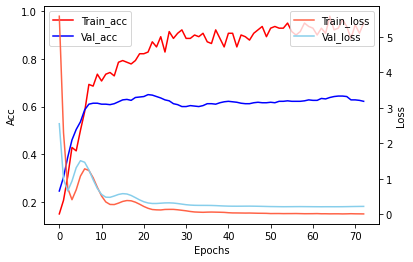

In [51]:
history = residual_inception_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'Residual Inception GCN', issave=False)

#### Evaluate

In [52]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = residual_inception_GCN_model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Residual Inception GCN Classification Report:\n{report}')

LOG >>> Residual Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.34      0.75      0.46       113
    Genetic_Algorithms       0.76      0.75      0.76       150
       Neural_Networks       0.80      0.42      0.56       306
 Probabilistic_Methods       0.69      0.52      0.59       167
Reinforcement_Learning       0.58      0.73      0.65        79
         Rule_Learning       0.40      0.47      0.43        62
                Theory       0.46      0.52      0.49       123

              accuracy                           0.57      1000
             macro avg       0.58      0.60      0.56      1000
          weighted avg       0.64      0.57      0.57      1000



#### Visualization

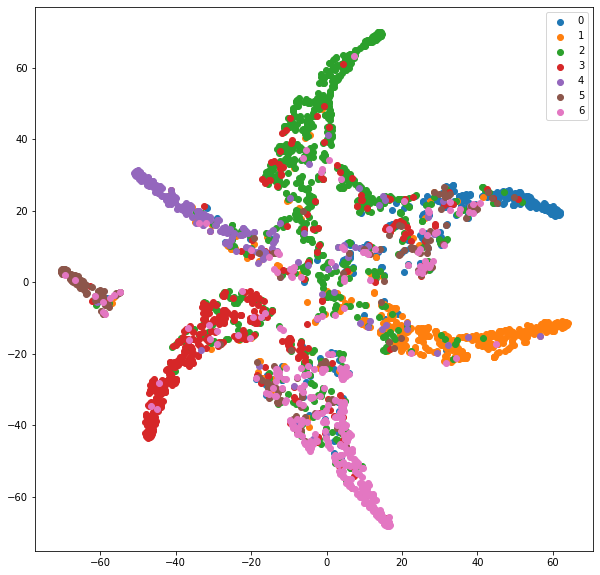

In [53]:
activations = residual_inception_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

## Inception + gated skip connection

#### Build Model 

In [54]:
gated_residual_inception_GCN_model = GatedSkipConnectionGCN(C.dropout, inception=True, isgate=True)

optimizer = Adam(lr=C.learning_rate)
gated_residual_inception_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

Epoch 1/200
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
1/1 [==============================] - 2s 2s/step - loss: 5.5802 - acc: 0.1643 - val_loss: 2.5636 - val_acc: 0.1420
Epoch 2/200
1/1 [==============================] - 1s 590ms/step - loss: 2.3031 - acc: 0.2143 - val_loss: 1.0049 - val_acc: 0.1740
Epoch 3/200
1/1 [==============================] - 1s 582ms/step - loss: 0.7448 - acc: 0.3000 - val_loss: 0.6835 - val_acc: 0.2260
Epoch 4/200
1/1 [==============================] - 1s 587ms/step - loss: 0.4229 - acc: 0.3857 - val_loss: 0.9687 - val_acc: 0.2480
Epoch 5/200
1/1 [==============================] - 1s 593ms/step - loss: 0.7077 - acc: 0.4286 - val_loss: 1.3553 - val_acc: 0.2620
Epoch 6/200
1/1 [==============================] - 1s 588ms/step - loss: 1.0921 - acc: 0.5071 - val_loss: 1.5641 - val_acc: 0.2560
Epoch 7/200
1/1 [==============================] - 1s 585ms/step - 

1/1 [==============================] - 1s 588ms/step - loss: 0.1171 - acc: 0.8786 - val_loss: 0.4008 - val_acc: 0.4360
Epoch 63/200
1/1 [==============================] - 1s 589ms/step - loss: 0.1121 - acc: 0.9071 - val_loss: 0.4064 - val_acc: 0.4400
Epoch 64/200
1/1 [==============================] - 1s 591ms/step - loss: 0.1163 - acc: 0.9000 - val_loss: 0.4210 - val_acc: 0.4460
Epoch 65/200
1/1 [==============================] - 1s 594ms/step - loss: 0.1326 - acc: 0.8857 - val_loss: 0.4327 - val_acc: 0.4180
Epoch 66/200
1/1 [==============================] - 1s 587ms/step - loss: 0.1407 - acc: 0.9143 - val_loss: 0.4344 - val_acc: 0.4020
Epoch 67/200
1/1 [==============================] - 1s 593ms/step - loss: 0.1426 - acc: 0.8929 - val_loss: 0.4281 - val_acc: 0.4020
Epoch 68/200
1/1 [==============================] - 1s 587ms/step - loss: 0.1349 - acc: 0.8857 - val_loss: 0.4219 - val_acc: 0.4000
Epoch 69/200
1/1 [==============================] - 1s 588ms/step - loss: 0.1220 - acc: 0

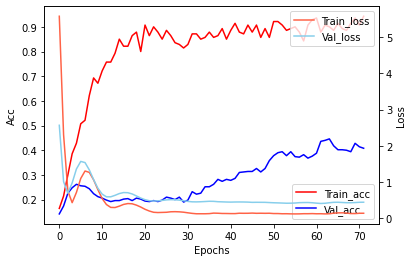

In [55]:
history = gated_residual_inception_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'Gated Residual Inception GCN', issave=False)

#### Evaluate

In [56]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

# y_pred = gated_residual_inception_GCN_model.predict([A_te, X_te], batch_size=N)
y_pred = gated_residual_inception_GCN_model.predict([A, X], batch_size=N)[test_mask]
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Gated Residual Inception GCN Classification Report:\n{report}')

LOG >>> Gated Residual Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.36      0.59      0.45       113
    Genetic_Algorithms       0.71      0.43      0.53       150
       Neural_Networks       0.63      0.42      0.50       306
 Probabilistic_Methods       0.60      0.31      0.40       167
Reinforcement_Learning       0.54      0.33      0.41        79
         Rule_Learning       0.22      0.26      0.24        62
                Theory       0.25      0.63      0.36       123

              accuracy                           0.43      1000
             macro avg       0.47      0.42      0.41      1000
          weighted avg       0.53      0.43      0.44      1000



#### Visualization

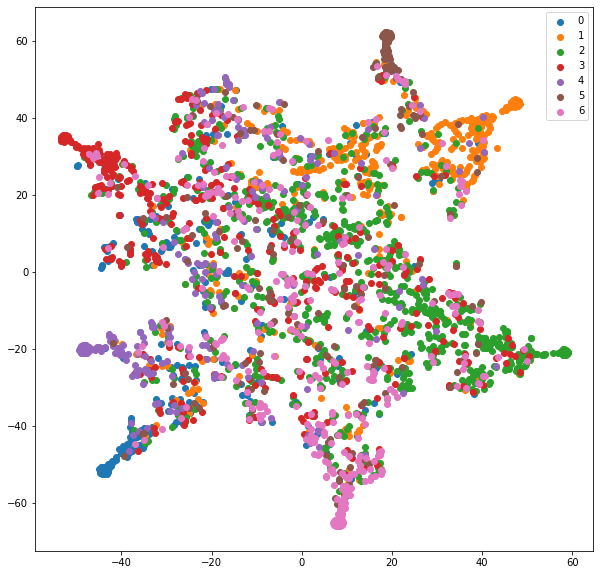

In [57]:
activations = gated_residual_inception_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)